In [42]:
from abc import ABC
from typing import List

import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.neighbors
import scipy, scipy.sparse

import pandas as pd
import numpy as np
import os
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [61]:
# copy dataset from drive
if not os.path.exists('the-movies-dataset_recommender-systems.zip'):
    !cp "/content/drive/MyDrive/DANsem3/SR/the-movies-dataset_recommender-systems.zip" .
    !unzip -q the-movies-dataset_recommender-systems.zip

# data loading and overview

In [44]:
movies_metadata = pd.read_csv('movies_metadata.csv')
# there are 3 bad records in columm "id", removing them:
movies_metadata.id = pd.to_numeric(movies_metadata.id, errors='coerce')

ratings = pd.read_csv('ratings_small.csv')

In [4]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [49]:
# some dataset records + titles
ratings.merge(movies_metadata[['id', 'title']], left_on='movieId', right_on='id').head()

,userId,movieId,rating,timestamp,id,title
0,1,1371,2.5,1260759135,1371.0,Rocky III
1,4,1371,4.0,949810302,1371.0,Rocky III
2,7,1371,3.0,851869160,1371.0,Rocky III
3,19,1371,4.0,855193404,1371.0,Rocky III
4,21,1371,3.0,853852263,1371.0,Rocky III


,mean,std,count
movieId,,,
1,3.872470,0.958981,247
2,3.401869,0.880714,107
3,3.161017,1.150115,59
4,2.384615,0.938835,13
5,3.267857,0.948512,56


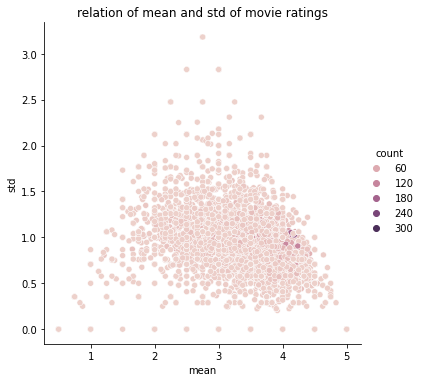

In [52]:
movie_stats = ratings.groupby('movieId').agg({'rating':['mean','std', 'count']})
movie_stats.columns = movie_stats.columns.get_level_values(1)

sns.relplot(data=movie_stats, 
            x='mean', y='std', hue='count').set(title='relation of mean and std of movie ratings')
movie_stats.head()

,mean,std,count
userId,,,
1,2.550000,0.887041,20
2,3.486842,0.901753,76
3,3.568627,0.741752,51
4,4.348039,0.947616,204
5,3.910000,0.565775,100


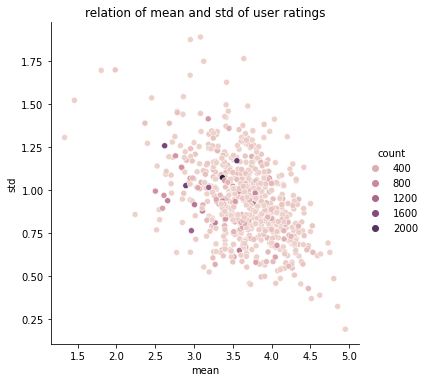

In [9]:
user_stats = ratings.groupby('userId').agg({'rating':['mean','std', 'count']})
user_stats.columns = user_stats.columns.get_level_values(1)

sns.relplot(data=user_stats, 
            x='mean', y='std', hue='count').set(title='relation of mean and std of user ratings')
user_stats.head()

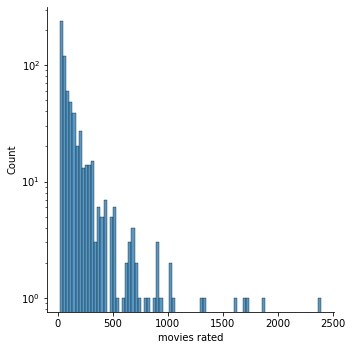

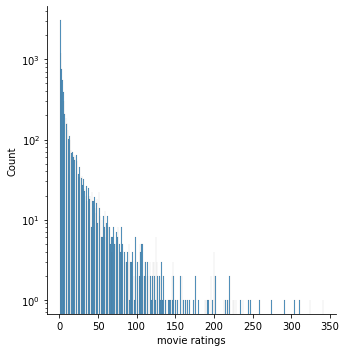

In [10]:
sns.displot(data=user_stats, x='count').set(xlabel='movies rated',yscale='log')
sns.displot(data=movie_stats, x='count').set(xlabel='movie ratings',yscale='log')

# user-user collaborative KNN
(not enough data for item-item KNN)

In [11]:
train_ratings, test_ratings = sklearn.model_selection.train_test_split(ratings,
        test_size=1000,
        random_state=42
        )

In [12]:
train_ratings.head()

,userId,movieId,rating,timestamp
24079,173,107,3.0,875357448
22729,159,1911,1.0,1183518395
21590,150,1784,2.5,1114308739
41186,295,1517,4.0,1100129122
10926,73,4713,4.5,1409205919


In [60]:
class KNNrecommender(ABC):
    def __init__(self, data, value_name='rating', row_name='userId',
                 col_name='movieId', metric='euclidean',):
        super(KNNrecommender, self).__init__()
        self.row_name = row_name
        values = data[value_name].to_list()
        row, column = data[row_name].to_list(), data[col_name].to_list()

        self.sparse_ratings = scipy.sparse.coo_matrix((values, (row, column)))
        self.knn = sklearn.neighbors.NearestNeighbors(n_neighbors=5,
                                                      metric=metric)
        self.knn.fit(self.sparse_ratings)

    def predict(self, user_id: int) -> List[int]:
        """
        Predicts ranking of movies to watch for a user.

        Parameters
        ----------
        user_id : int
            User's id from the data set.

        Returns
        -------
        List[int]
            List of movies ids. Best recommendations first.
        """
        feature_vector = self.sparse_ratings.getrow(user_id)
        distances, indexes = self.knn.kneighbors(feature_vector, 5)
        recommended = []

        for i in indexes[0][1:]:
            K = 5
            neighbour = self.sparse_ratings.getrow(i).toarray()[0]
            # search for 5 best rated movies by neighbout among unseen ones
            cols_to_consider = (
                (feature_vector.toarray() == 0) & (neighbour != 0)
                )[0]
            cols_to_consider = np.arange(
                len(cols_to_consider)
                )[cols_to_consider]
            # get the indexes of the best guesses
            Kbest_from_cols_to_consider = np.argsort(
                neighbour[cols_to_consider]
                )[::-1][-K:]
            Kbest_idxs_from_neighbour = \
                cols_to_consider[Kbest_from_cols_to_consider]

            recommended.append(Kbest_idxs_from_neighbour)
        return np.concatenate(recommended)

    def predict_score(self, user_id: int, movie_id: int) -> float:
        """
        Predicts score for a given movie that a user would give.

        Parameters
        ----------
        user_id : int
            User's id from the data set.
        movie_id : int
            Movie's id from the data set.

        Returns
        -------
        float
            Predicted movie's score in range [0.5, 5]
        """
        # the 2 lines below make sure that this method works
        # for both user-user and item-item filtering
        j = movie_id if (self.row_name == 'userId') else user_id
        row = user_id if (self.row_name == 'userId') else movie_id
        # early stop if the movie was not present in training set
        if self.sparse_ratings.getcol(j).toarray().sum() == 0:
            return np.nan
        # search for nearest neighbours in training set
        distances, indexes = self.knn.kneighbors(
            self.sparse_ratings.getrow(row), 100
            )
        # make a list of "movie_id" movie ratings abong neighbours
        users_alike_ratings = np.stack(
            [self.sparse_ratings.getrow(i).getcol(j).toarray()[0, 0]
             for i in indexes[0]
             ])
        if sum(users_alike_ratings != 0) == 0:
            return np.nan

        # create weights based on calculated distance
        weights = scipy.special.softmax(
            -distances[0][users_alike_ratings != 0]
            )
        # calculate weighted rating for a movie
        predicted_rating = \
            (weights * users_alike_ratings[users_alike_ratings != 0]).sum()
        return predicted_rating

In [14]:
user_user_RS = KNNrecommender(data=train_ratings, value_name='rating', row_name='userId', col_name='movieId', metric='euclidean')

In [15]:
user_user_RS.predict(1)

array([1022,  914,  724,  277, 1562, 2082, 1892, 1687,   88,   65, 1047,
        914,  230, 1267, 1188])

In [16]:
user_user_RS.predict_score(128,1028)

3.0

In [17]:
test_ratings

,userId,movieId,rating,timestamp
19090,128,1028,5.0,1049690908
99678,665,4736,1.0,1010197684
18455,120,4002,3.0,1167420604
35755,257,1274,4.0,1348544094
66536,468,6440,4.0,1296191715
...,...,...,...,...
35485,254,337,4.0,845157407
75961,528,4223,4.0,1143758139
53754,388,432,2.5,1167703743
78008,544,6,4.5,1442495715


In [18]:
test_ratings[:5].progress_apply(lambda x: user_user_RS.predict_score(x.userId, x.movieId), axis=1)

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


19090    3.000000
99678         NaN
18455         NaN
35755         NaN
66536    3.220271
dtype: float64

In [22]:
for metric in ['euclidean', 'cosine', 'manhattan']:
    user_user_RS = KNNrecommender(data=train_ratings, value_name='rating', row_name='userId', col_name='movieId', metric=metric)
    test_ratings['preds_'+metric] = test_ratings.progress_apply(lambda x: user_user_RS.predict_score(x.userId, x.movieId), axis=1)

100%|██████████| 1000/1000 [12:31<00:00,  1.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 1000/1000 [14:59<00:00,  1.11it/s]


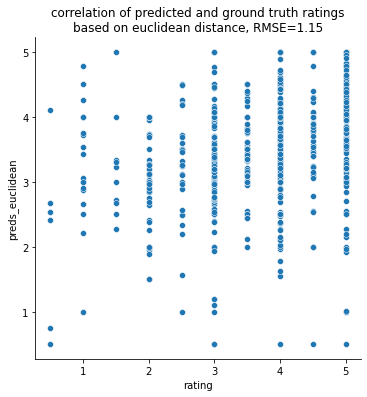

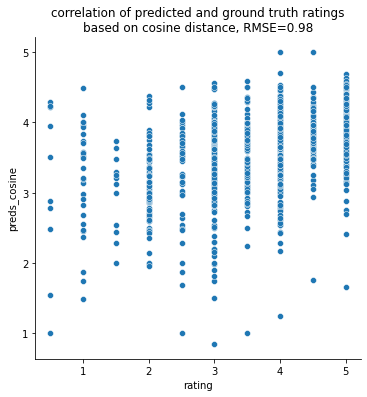

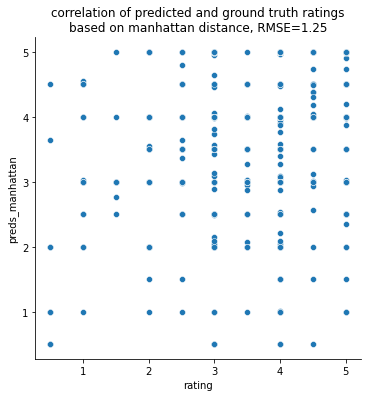

In [37]:
for metric in ['euclidean', 'cosine', 'manhattan']:
    tmp_ratings = test_ratings[['rating', 'preds_'+metric]].dropna()
    RMSE = (tmp_ratings['rating'] - tmp_ratings['preds_'+metric]).pow(2).mean()**0.5
    sns.relplot(data=test_ratings, x='rating', y='preds_'+metric).set(title=f'correlation of predicted and ground truth ratings\nbased on {metric} distance, RMSE={RMSE:1.2f}')

In [39]:
test_ratings.to_csv('/content/drive/MyDrive/DANsem3/SR/KNNresults.csv', index=False)

In [62]:
import pickle

In [65]:
for metric in ['euclidean', 'cosine', 'manhattan']:
    user_user_RS = KNNrecommender(data=train_ratings, value_name='rating', row_name='userId', col_name='movieId', metric=metric)
    
    with open(f'models/KNN_{metric}_metric.pickle', 'wb') as handle:
        pickle.dump(user_user_RS, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # with open(f'models/KNN_{metric}_metric.pickle', 'rb') as handle:
    #     b = pickle.load(handle)